<a href="https://colab.research.google.com/github/harperd17/cloud_classification/blob/main/modeling/UNet_segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/harperd17/cloud_classification.git

Cloning into 'cloud_classification'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 107 (delta 8), reused 0 (delta 0), pack-reused 84
Receiving objects: 100% (107/107), 1.86 MiB | 19.83 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [ ]:
!pip install torchsat
from torchsat.transforms import transforms_seg

     |████████████████████████████████| 46 kB 2.2 MB/s 


In [ ]:
import torch
import torchvision
import glob
from PIL import Image
import cv2
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

     |████████████████████████████████| 88 kB 4.2 MB/s 
     |████████████████████████████████| 58 kB 8.5 MB/s 
     |████████████████████████████████| 376 kB 55.4 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=11b1ec07065207b8e3f937a84abc0512fdb122e23908074a7a39be48f7bbebb3
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=b438a936edd3df9ea0ca4acfc7d2a0a613b700113dfa137a1457ed74fc546639
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
drive._mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!git clone https://github.com/EdwardRaff/Inside-Deep-Learning.git
%run /content/Inside-Deep-Learning/idlmam.py

Cloning into 'Inside-Deep-Learning'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 34 (delta 10), reused 28 (delta 7), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [ ]:
from tqdm.autonotebook import tqdm
from cloud_classification.helpers.helper_functions import CloudData, show_image_and_masks, decode_pixels, train_network, show_predicted_masks, get_accuracy, get_auc

from sklearn.metrics import roc_curve, auc

## Set up the Directory for the Images

In [ ]:
#data_dir = '/content/drive/MyDrive/Data690/Project/Data'
data_dir = '/content/drive/Shareddrives/DavidHarper_Data690_Project/Data'

## Load the train.csv which holds the file names, classifications, and mask information

In [ ]:
train_data = pd.read_csv(data_dir+'/train.csv')

In [ ]:
# now random sample from the train_data so that I don't have to train these networks on such a large amount of data - the final model should be trained with all the data though
image_names = pd.Series([parts[0] for parts in train_data['Image_Label'].str.split('_')])
sampled = pd.Series(pd.Series(image_names).unique()).sample(500)
train_data_sampled = train_data[image_names.isin(sampled)]

## Do a Train / Validation Split

In [ ]:
train_valid_images, test_images = train_test_split(sampled,train_size=0.9)
train_images, valid_images = train_test_split(train_valid_images,train_size=0.8)

In [ ]:
test = train_data[image_names.isin(test_images)]
train = train_data[image_names.isin(train_images)]
valid = train_data[image_names.isin(valid_images)]

## Create the CloudData objects and DataLoaders

In [ ]:
output_width=512
output_height=512

test_dataset = CloudData(data_dir, test, output_width=output_width, output_height=output_height)#, transform=transform_list)
train_dataset = CloudData(data_dir, train, output_width=output_width, output_height=output_height)#, transform=transform_list)
valid_dataset = CloudData(data_dir, valid, output_width=output_width, output_height=output_height)#, transform=transform_list)

print("There are {} test images".format(len(test_dataset)))
print("There are {} train images".format(len(train_dataset)))
print("There are {} valid images".format(len(valid_dataset)))

batch_size = 16

test_loader = DataLoader(test_dataset,batch_size=batch_size)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=batch_size)

There are 50 test images
There are 360 train images
There are 90 valid images


/content/cloud_classification/helpers/helper_functions.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask_df['Label'] = [parts[1] for parts in mask_df['Image_Label'].str.split('_')]
/content/cloud_classification/helpers/helper_functions.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask_df['Image'] = [parts[0] for parts in mask_df['Image_Label'].str.split('_')]


## Get the GPU Device Configured

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Modeling

In [ ]:
#Define our helper function that creates a hidden layer for a CNN - this function was copied from the text
def cnnLayer(in_filters, out_filters, kernel_size=3):
 """
 in_filters: how many channels are in the input to this layer
 out_filters: how many channels should this layer output
 kernel_size: how large should the filters of this layer be
 """
 padding = kernel_size//2
 return nn.Sequential( 
 nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
 nn.BatchNorm2d(out_filters),
 nn.LeakyReLU(), # I'm not setting the leak value to anything just to make the code shorter. 
 )

In [ ]:
class UNetBlock2d(nn.Module): #Our class extends nn.Module, all PyTorch layers must extend this - I got this code from the text 
  def __init__(self, in_channels, mid_channels, out_channels=None, layers=1, sub_network=None, filter_size=3):
    """ 
    in_channels: the number of channels in the input to this block
    mid_channels: the number of channels to have as the output for each convolutional 
    filter
    out_channels: if not `None`, ends the network with a 1x1 convolution to convert the 
    number of output channels to a specific number. 
    layers: how many blocks of hidden layers to create on both the input and output 
    side of a U-Net block
    sub_network: the network to apply after shrinking the input by a factor of 2 using 
    max pooling. The number of output channels should be equal to `mid_channels`
    filter_size: how large the convolutional filters should be
    """
    super().__init__()

    #Start preparing the layers used to process the input
    in_layers = [cnnLayer(in_channels, mid_channels, filter_size)]
    #If we have a sub-network, we will double the number of inputs to the output. So lets figure that out now
    if sub_network is None:
      inputs_to_outputs = 1
    else:
      inputs_to_outputs = 2
    #Preparing the layers used to make the final output, which has extra input channels from any sub-network
    out_layers = [ cnnLayer(mid_channels*inputs_to_outputs, mid_channels, filter_size)]
    #Make the additional hidden layers used for the input and output
    for _ in range(layers-1):
      in_layers.append(cnnLayer(mid_channels, mid_channels, filter_size))
      out_layers.append(cnnLayer(mid_channels, mid_channels, filter_size))
    #Use 1x1 Convolutions to ensure a specific output size
    if out_channels is not None:
      out_layers.append(nn.Conv2d(mid_channels, out_channels, 1, padding=0))
    #define our three total sub-networks:
    #1) in_model performs the intial rounds of convolution
    self.in_model = nn.Sequential(*in_layers)
    #2) our subnetwork works on the max-pooled result. We will add the pooling and up-scaling directly into the sub-model
    if sub_network is not None:
      self.bottleneck = nn.Sequential(
        nn.MaxPool2d(2), #Shrink
        sub_network, #process the smaller resolution
        #expand back up
        nn.ConvTranspose2d(mid_channels, mid_channels, filter_size, padding=filter_size//2, 
        output_padding=1, stride=2)
        ) 
    else:
      self.bottleneck = None
    #3) the output model that processes the concatinated result, or just the output from in_model if no sub-network was given
    self.out_model = nn.Sequential(*out_layers)

  #The forward function is the code that takes an input and produce an output. 
  def forward(self, x):
    #compute the convolutions at the current scale
    full_scale_result = self.in_model(x) #(B, C, W, H)
    #check if we have a bottleneck to apply
    if self.bottleneck is not None:
      #(B, C, W, H) shape because bottleneck does both the pooling & expansion
      bottle_result = self.bottleneck(full_scale_result)
      #Now shape (B, 2*C, W, H)
      full_scale_result = torch.cat([full_scale_result, bottle_result], dim=1)
    #compute the output on the concatenated (or not!) result
    return self.out_model(full_scale_result)

In [ ]:
classes = 4 # there are 4 cloud types

In [ ]:
unet_model = nn.Sequential(
  UNetBlock2d(3, 32, layers=2, sub_network=
    UNetBlock2d(32, 64, out_channels=32, layers=4, sub_network=
      UNetBlock2d(64, 128, out_channels=64, layers=8, sub_network=
        UNetBlock2d(128,256,out_channels=128,layers=8)),
    ),
  ),
  #Prediction for _every_ location
  nn.Conv2d(32, classes, (3,3), padding=1), #Shape is now (B, 1, W, H)
  ) 

In [ ]:
loss_func = smp.losses.DiceLoss(mode='multilabel')
optimizer = torch.optim.Adam(unet_model.parameters())#,lr=0.01)

In [ ]:
seg_results_unet = train_network(unet_model, loss_func, train_loader, epochs=25, device=device, val_loader=valid_loader,score_funcs={'Accuracy':get_accuracy, 'AUC':get_auc})

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

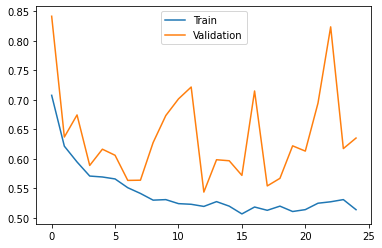

In [ ]:
plt.plot(seg_results_unet['train loss'],label='Train')
plt.plot(seg_results_unet['val loss'],label='Validation')
plt.legend();

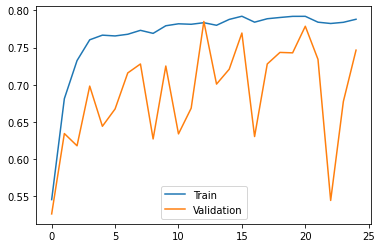

In [ ]:
plt.plot(seg_results_unet['train Accuracy'],label='Train')
plt.plot(seg_results_unet['val Accuracy'],label='Validation')
plt.legend();

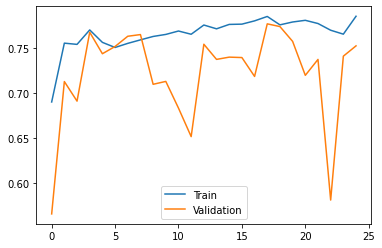

In [ ]:
plt.plot(seg_results_unet['train AUC'],label='Train')
plt.plot(seg_results_unet['val AUC'],label='Validation')
plt.legend();

In [ ]:
unet_model = unet_model.cpu()

(<Figure size 864x1296 with 42 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6fddaaf590>,
       dtype=object))

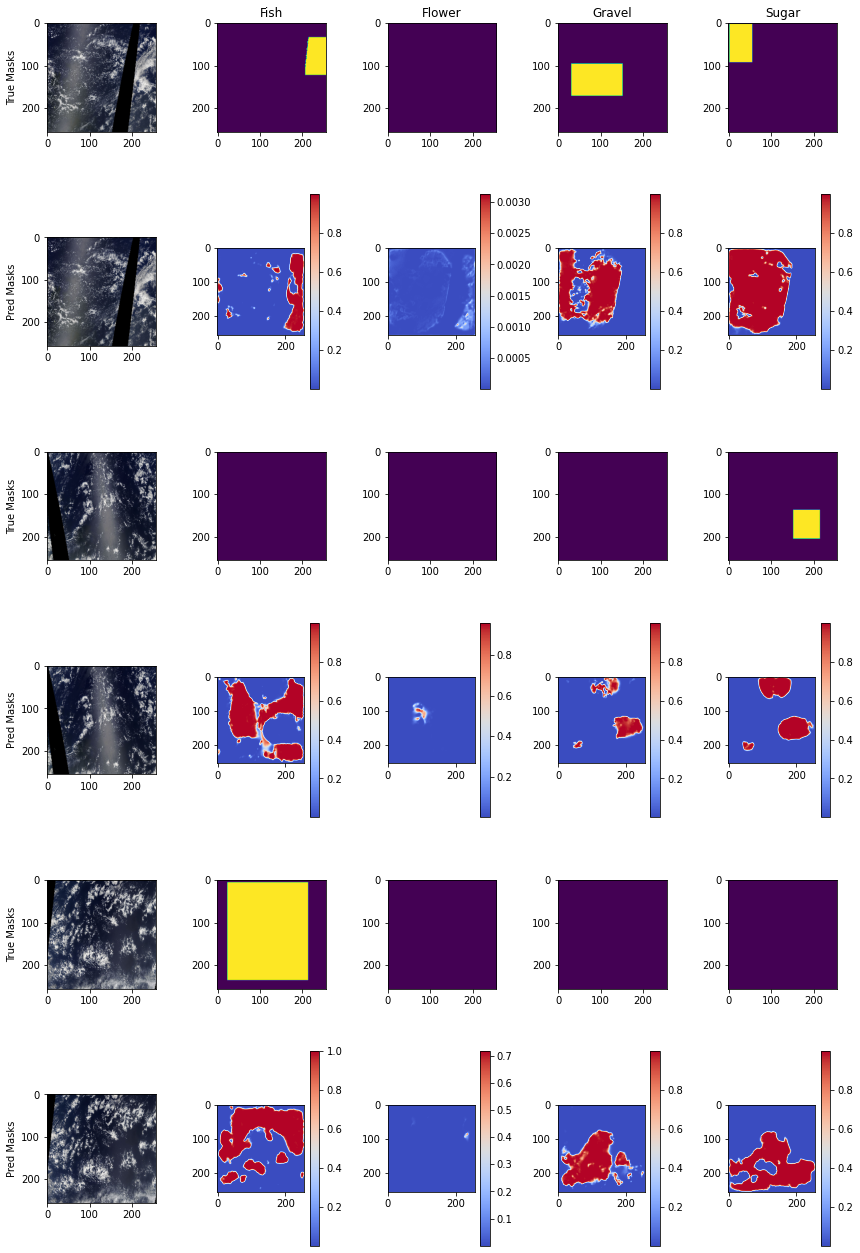

In [ ]:
to_show = 3
with torch.no_grad():
  sample_predictions = [unet_model(train_dataset[i][0].unsqueeze(0)).squeeze(0) for i in range(to_show)]
  sample_masks = [train_dataset[i][1] for i in range(to_show)]
  original_images = [train_dataset[i][0].permute(1,2,0) for i in range(to_show)]
show_predicted_masks(sample_predictions,sample_masks, original_images,classes=train_dataset.classes);

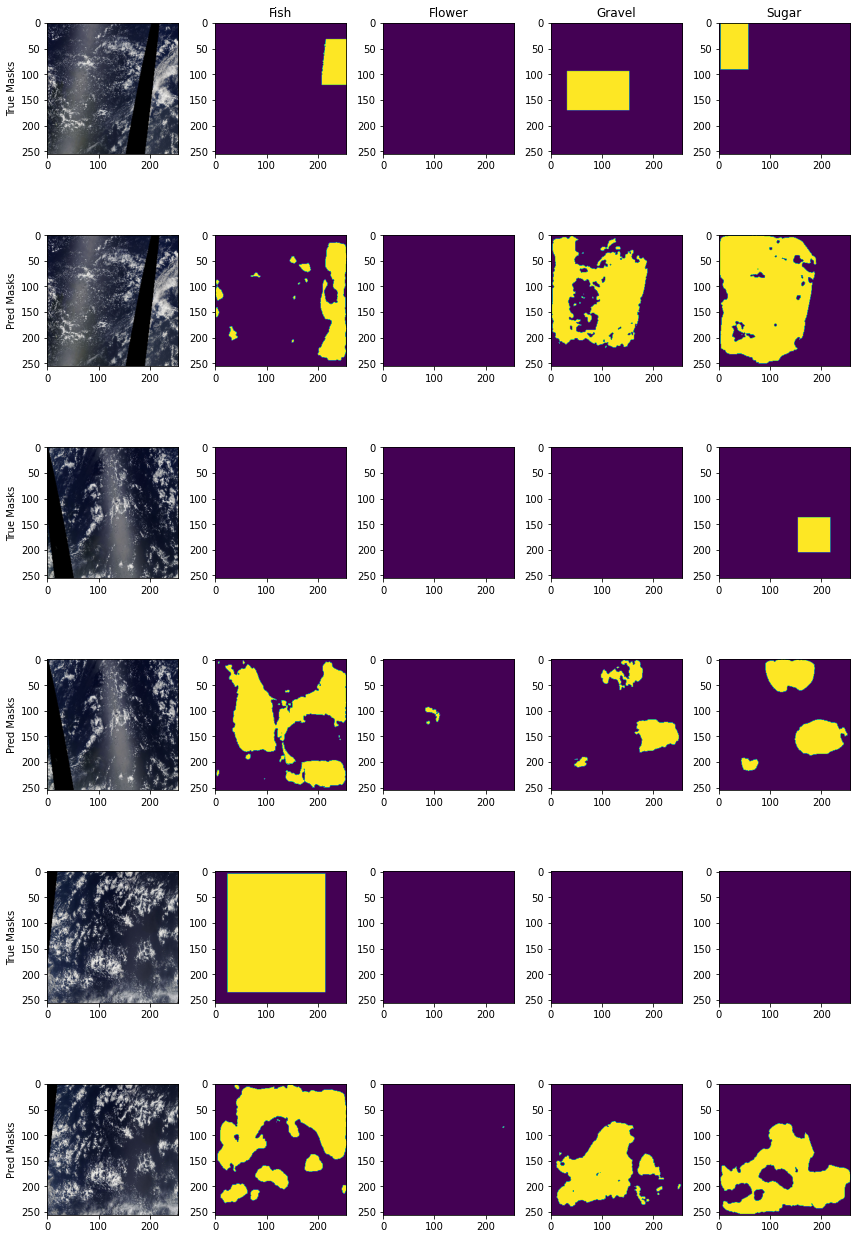

In [ ]:
# now show what the predicted mask is using a threshold
thresh = 0.5
sample_pred_masks = [(s>thresh).float() for s in sample_predictions]
show_predicted_masks(sample_pred_masks,sample_masks, original_images,classes=train_dataset.classes,cmap=None);